# 제1회 KRX 금융 빅데이터 활용 아이디어 경진대회

## 주제 : 개인투자자의 ktop30 감정지표

- __chapter 1. 정형데이터__
<br/>
- __chapter 2. 비정형 데이터__
    - 비정형 데이터 크롤링
        - 유튜브댓글 api
        - 네이버금융 종목토론방 댓글 크롤링
    - 비정형 데이터 전처리
        - 댓글 전처리
        - 댓글 토크나이징
        - 댓글 레이블링
        - 학습데이터 생성 (댓글 도미넌스 기반 랜덤추출)
        - 날짜별 데이터 정리
        <br/>
- __chapter 3. BERT 모델링__
    - 모델 학습
    - 모델 예측
    <br/>
- __chapter 4. 시각화 및 서비스__

---

## Abstract
<span style="font-size:110%">기존의 경제학 및 자본시장에서는 합리적인 개인들이 주어진 정보를 모두 활용하여 이성적인 판단에 근거하여 행동한다고 전제하였습니다. 그렇지만 현실의 경제 및 자본시장에서는 개인들의 __비이성적인 행동 양상__을 보이는 경우가 많았고, 1990년대 이후로 이러한 비이성적인 행동을 설명하기 위해 행동 경제학(Behavioral Economics)이 주류로 등장하기 시작했습니다. 특히 행동 경제학파들은 자본 시장에서의 비이성적인 행동들이 존재하며, 자본 시장 참여자들의 잡음(noise) 혹은 감정(sentiment)이 수익률에 영향을 미친다는 것을 근거로 효율적 시장 가설이 완벽하지 않다고 주장했습니다.(Brown, 1999; Shleifer and Summers, 1990) 또한, 자본 시장의 비이성적인 행동은 한국 자본 시장에서도 비슷한 양상을 보인다는 것으로 나타났습니다.(Kim and Park, 2015)</span> 

<span style="font-size:110%">저희 팀은 이러한 행동 경제학의 주장을 근거로 시장의 비이성적인 행동을 포착할 수 있는 방법을 고안하고자 합니다. 과거의 비이성적인 행동을 포착하기 위한 방법으로는 시카고옵션거래소 변동성지수(Chicago Board Options Exchange Volatility Index; VIX Index)를 사용하는 것이 대표적이었습니다. 하지만 최근 딥러닝 기법의 발전으로 문서를 분석하여 작성자의 감성을 분석하는 __감성 분석(sentiment analysis)__ 기법의 정확도가 크게 향상하였습니다. 이에 따라 VIX 지수라는 시장의 참여 결과 데이터를 통해 참여자의 비이성적 행동을 포착하는 간접적인 방법이 아닌 댓글, SNS, 뉴스 등 시장 참여자와 관련된 문서를 감정 분석하여 감정에 따른 비이성적인 행동을 포착하려는 시도가 있었습니다(Li et al, 2021; 김명진 외 3, 2020; 홍성혁, 2020). 이러한 시도를 근거로 저희 팀은 다양한 문서 중에서 기존 연구에서 사용된 데이터이며, 특히 개인 투자자들의 감정을 파악하기에 용이한 __KTOP30 종목의 네이버의 종목 토론방__의 문서와 기존 연구에서 사용되지는 않았지만 최근 정보를 얻는데 많이 사용되고 있는 경로인 __유튜브(삼프로TV)의 댓글__을 감정 분석을 위한 데이터셋으로 선정하였습니다.</span> 

<span style="font-size:110%">또한, CNN의 Fear and Greed Index와 alternative사의 Crypto Fear and Greed Index를 참고하여 저희 팀만의 공포탐욕 지수를 구성하고자 하였습니다. CNN의 공포탐욕 지수에서는 7가지의 지표(Market Momentum, Stock Price Breadth, Put and Call Options, Market Volatility, Safe Haven Demand, Junk Bond Demand)로 구성되어 있으며, 가상화폐의 공포탐욕 지수는 5가지 지표(Volatility, Market Momentum/Volume, Social Medai, Dominance, Trends)로 구성되어 있습니다. CNN의 경우에는 모두 기존의 주식 시장에서 보조 지표로 활용되는 것들과 채권시장의 수익률 등으로 지수가 구성되어 있으며, 가상화페의 경우 기존의 변동성과 모멘텀 등의 보조 지표를 차용함과 동시에 SNS나 구글 트렌드의 검색량 통계를 지수에 포함시킴으로써 기존의 보조지표와는 다른 지표를 포함시킨 것이 특징이라 할 수 있습니다.</span> 
    
<span style="font-size:110%">저희 팀은 위의 다양한 지표 중에서도 두 지수에 공통적으로 사용된 __VIX 지수__를 KRX에서 제공하는 VKOPSI 지수로 대체하여 포함시켰습니다. 또한, Baker와 Wurgler(2007)가 제안한 투자 심리지수에 포함되어 있는 __거래회전율__을 KTOP30 종목을 기준으로 일일 거래회전율(거래량 / 상장 주식 수)로 변형하여 지수에 포함시켰습니다. 또한, 거시적인 대외 환경을 고려할 수 있는 환율 데이터를 포함하였으며, 마지막으로 KTOP30 종목의 종목 토론방 데이터와 유튜브 댓글 데이터를 감성 분석한 후, __1과 0사이로 점수화하여 1에 가까울수록 탐욕에, 0에 가까울수록 공포에 가까운 감성을 나타내도록 라벨링__하였습니다. 훈련 기간은 과열과 침체 양상을 보이는 2020년 6월 1일부터 2022년 6월 30일까지입니다.</span> 

<span style="font-size:110%">저희 팀이 만든 공포 탐욕 지수를 통해 기존의 참여자들의 심리를 숫자 데이터를 통해 간접적으로 파악하던 방식에서 참여자들의 심리를 댓글 등의 문서를 통해 파악하여 좀더 명확한 __참여자들의 심리를 파악__할 수 있으며, 이를 통해 __주식 시장의 과열과 침체__를 유추해봄으로써 참여자의 의사결정에 큰 도움이 될 것으로 기대됩니다.</span> 

---

## chapter 1. 정형 데이터

### 1.1 거래 회전율
 보통의 거래회전율은 연간으로 계산하므로 1년의 입회일수(약 250일)를 곱해주는 (일일 거래량 * 입회일수) / 상장 주식 수의 평균 의 공식으로 계산하는데, 저희 팀은 다른 데이터와의 연결성을 위해 __일일 거래회전율 (일일 거래량의 총합 / 상장 주식 수의 평균)__ 로 계산하였습니다. 또한, KOSPI 거래회전율이 아닌 __KTOP30의 거래회전율(30개 종목의 총 거래량의 자연로그 값 / 30개 종목의 총 상장 주식 수 평균의 자연로그 값)__ 으로 공식을 변형하여 계산하였습니다. 각 값의 크기가 매우 크기 때문에 스케일링을 위해 자연로그 값을 취해줬습니다. 저희의 기준으로 __0.5 이상일 경우 탐욕(greed), 0.5 이하일 경우 공포(fear)__ 로 설정하였습니다.

In [32]:
from pykrx import stock
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [33]:
codes = ['005930', '035420', '006400', '051910', '035720', '000100', '017670', '005490', '012330',
 '096770', '000810', '011170', '005380', '068270', '009150', '090430', '028260', '139480', '035760',
 '000660', '009540', '066570', '000270', '251270', '032830', '105560', '000720', '055550', '034220', '006800']

In [37]:
start_date = "20200601"
end_date = "20220630"

df = stock.get_market_ohlcv(start_date, end_date, '005930').reset_index()[['날짜', '거래량']]
df['거래량'] = 0 # 빈공간 생성

for code in codes:
    df['거래량'] += stock.get_market_ohlcv(start_date, end_date, code)['거래량'].values
len(df)

516

In [12]:
stocks = []
for date in df['날짜'].dt.strftime("%Y%m%d"):
    df2 = stock.get_market_cap(date)
    stocks.append(sum(df2.loc[codes, '상장주식수']))
len(stocks)

516

In [38]:
df['거래량'] = np.log(df['거래량'])
stock_log = np.log(np.array(stocks) / 30)
df['거래량'] = round(df['거래량'] / stock_log, 5)
df['거래량'] = (df['거래량'] - min(df['거래량'])) /(max(df['거래량']) - min(df['거래량']))
df

,날짜,거래량
0,2020-06-01,0.381022
1,2020-06-02,0.410100
2,2020-06-03,0.746989
3,2020-06-04,0.658981
4,2020-06-05,0.460427
...,...,...
511,2022-06-24,0.288971
512,2022-06-27,0.226428
513,2022-06-28,0.139195
514,2022-06-29,0.215933


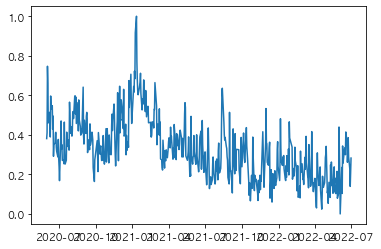

In [39]:
plt.plot(df['날짜'], df['거래량'])

### 1.2 환율
 대외 충격에 민감한 우리나라의 특성을 반영해주기 위해 원/달러 환율 데이터를 지수에 포함시켰습니다. 환율 데이터를 통해 거시적인 경제 환경을 반영할 수 있으며, 단기적인 외국 자본의 진입 및 이탈을 반영할 수 있을 것으로 기대됩니다. 이러한 환율 데이터는 과거의 경험을 바탕으로 max값을 1500, min값을 900으로 min-max-scaling해줬으며, 자본이 이탈하는 상황이 주식 시장에 있어서는 부정적인 상황이기 때문에 환율이 상승하는 상황을 공포(fear)로 나타내주기 위해 __1 - (min-max-scaling한 환율값)__ 을 해줘 위아래가 뒤집힌 환율 데이터를 지수에 반영하였습니다. 0.5보다 클 경우 탐욕(greed), 0.5보다 낮을 경우 공포(fear)를 나타냅니다.

<AxesSubplot:>

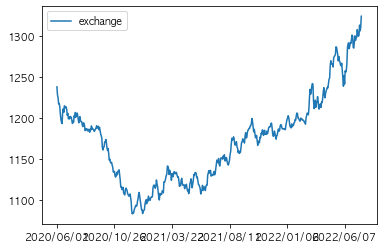

In [29]:
df_ex = pd.read_csv('exchange.csv', thousands = ',').transpose().drop(labels = ['통계표', '계정항목', '단위', '변환']).astype(float)
df_ex = df_ex.rename(columns={0:'exchange'})
df_ex.plot() # 원래 환율 데이터

In [30]:
df_ex['exchange'] = (df_ex['exchange'] - 900) / (1500 - 900)
df_ex['exchange'] = 1 - df_ex['exchange']
df_ex

,exchange
2020/06/01,0.437333
2020/06/02,0.453667
2020/06/03,0.459833
2020/06/04,0.471833
2020/06/05,0.471000
...,...
2022/07/12,0.332333
2022/07/13,0.311833
2022/07/14,0.323500
2022/07/15,0.316667


<AxesSubplot:>

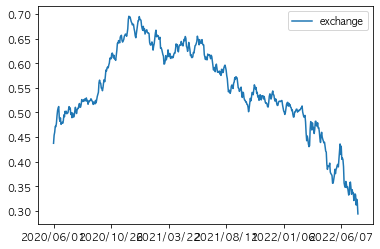

In [31]:
df_ex.plot()

---

## chapter 2. 비정형 데이터

### 2.1 비정형 데이터 크롤링

#### 2.1.1 유튜브댓글 api
- 유튜브 채널 '삼프로tv'에서 2020년 06월부터 2022년 06월 사이에 업로드된 영상의 댓글을 크롤링하였습니다.
- '영상 제목', '영상 업로드 날짜', '영상 아이디', '댓글 내용', '댓글 작성자', '댓글 작성 날짜', '좋아요 수'에 대한 정보를 가져왔습니다.
- 국내 시장에 대한 반응을 확인하기 위해 해외 시장에 관련된 영상이나 경제와 관련없는 영상에 달린 댓글들은 제외하였습니다.

In [ ]:
import pandas as pd
import datetime
import scrapetube
from googleapiclient.discovery import build

import warnings
warnings.filterwarnings('ignore')

In [ ]:
api_key = 'api_key'
youtube = build('youtube', 'v3', developerKey=api_key)

search_response = youtube.search().list(
    q = '삼프로tv',
    order = 'relevance',
    part = 'snippet',
    maxResults = 10
    ).execute()

channel_id = search_response['items'][0]['snippet']['channelId']

In [ ]:
videos = scrapetube.get_channel(channel_id)

video_ids = []

for video in videos:
    video_ids.append(video['videoId'])
    
len(video_ids)

In [ ]:
video_infos = []

for i in range(800):
    start = i * 50
    end = (i + 1) * 50
    video_request = youtube.videos().list(
        part="snippet",
        id=','.join(video_ids[start:end]))

    video_response = video_request.execute()

    for item in video_response['items']:
        title = item['snippet']['title']
        if ('글로벌 이슈체크' in title) or ('글로벌 마켓브리핑' in title) or ('직장인 vlog' in title):
            continue
        video_infos.append([item['snippet']['title'], item['snippet']['publishedAt'], item['id']])
        
df = pd.DataFrame(video_infos, columns=['title', 'video_date', 'id'])
print(len(df))
df.head()

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index('date')

In [ ]:
df_22 = df[(pd.DatetimeIndex(df.index).year == 2022) & (pd.DatetimeIndex(df.index).month <= 6)]
df_21 = df[(pd.DatetimeIndex(df.index).year == 2021)]
df_20 = df[(pd.DatetimeIndex(df.index).year == 2020) & (pd.DatetimeIndex(df.index).month >= 6)]

In [ ]:
comments_22 = []

for video_id in df_22['id']:
    api_obj = build('youtube', 'v3', developerKey=api_key)
    response = api_obj.commentThreads().list(part='snippet', videoId=video_id, maxResults=100).execute()
 
    while response:
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            comments_22.append([video_id, comment['textDisplay'], comment['authorDisplayName'], comment['publishedAt'], comment['likeCount']])
 
        if 'nextPageToken' in response:
            response = api_obj.commentThreads().list(part='snippet', videoId=video_id, pageToken=response['nextPageToken'], maxResults=100).execute()
        else:
            break

df1 = pd.DataFrame(comments_22, columns=['id', 'comment', 'author', 'comment_date', 'num_likes'])
print(len(df1))
df1.head()

In [ ]:
comments_21 = []

for video_id in df_21['id']:
    api_obj = build('youtube', 'v3', developerKey=api_key)
    response = api_obj.commentThreads().list(part='snippet', videoId=video_id, maxResults=100).execute()
 
    while response:
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            comments_21.append([video_id, comment['textDisplay'], comment['authorDisplayName'], comment['publishedAt'], comment['likeCount']])

        if 'nextPageToken' in response:
            response = api_obj.commentThreads().list(part='snippet', videoId=video_id, pageToken=response['nextPageToken'], maxResults=100).execute()
        else:
            break

df2 = pd.DataFrame(comments_21, columns=['id', 'comment', 'author', 'comment_date', 'num_likes'])
print(len(df2))
df2.head()

In [ ]:
comments_20 = []

for video_id in df_20['id']:
    api_obj = build('youtube', 'v3', developerKey=api_key)
    response = api_obj.commentThreads().list(part='snippet', videoId=video_id, maxResults=100).execute()
 
    while response:
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            comments_20.append([video_id, comment['textDisplay'], comment['authorDisplayName'], comment['publishedAt'], comment['likeCount']])
 
        if 'nextPageToken' in response:
            response = api_obj.commentThreads().list(part='snippet', videoId=video_id, pageToken=response['nextPageToken'], maxResults=100).execute()
        else:
            break
            
df3 = pd.DataFrame(comments_21, columns=['id', 'comment', 'author', 'comment_date', 'num_likes'])
print(len(df3))
df3.head()

In [ ]:
df_22 = df_22.reset_index()
df_21 = df_21.reset_index()
df_20 = df_20.reset_index()

In [ ]:
sampro_22 = pd.merge(df_22, df1, on='id', how='outer')
sampro_21 = pd.merge(df_21, df2, on='id', how='outer')
sampro_20 = pd.merge(df_20, df3, on='id', how='outer')

In [ ]:
sampro_22.to_csv('./sampro/sampro_22.csv', index=False)
sampro_21.to_csv('./sampro/sampro_21.csv', index=False)
sampro_20.to_csv('./sampro/sampro_20.csv', index=False)

In [ ]:
# sampro_2year = pd.concat([sampro_22, sampro_21, sampro_20])

#### 2.1.2 종목토론실 댓글 크롤링
- 종목토론실 댓글에서 '날짜', '댓글제목', '조회수', '좋아요', 싫어요' 를 크롤링 했습니다.
- 기업대상은 KODEX30의 기업입니다.

In [ ]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import datetime as dt


import warnings
warnings.filterwarnings('ignore')

In [ ]:
def get_code(symbol):
    krx = pd.read_csv('./krx_code.csv',encoding='utf-8')
    krx = krx.set_index('한글 종목약명')
    try:
        code = krx.at[symbol,'단축코드']
        return code
    except:
        print('종목명을 다시 확인해주세요.')
        return 0

def get_comment_csv(symbol,page,year,month,day):   
    code = get_code(symbol)
    date_list = [] # 날짜
    comment_list = [] # 댓글
    view_list = [] # 조회수
    good_list = [] # 좋아요
    bad_list = [] # 싫어요
    flag = 0
    for i in range(1,page+1):
        url = f'https://finance.naver.com/item/board.naver?code={code}&page={i}'
        headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36 Edg/100.0.1185.50'}
        res = requests.get(url, headers = headers)
        bs = BeautifulSoup(res.text, 'html.parser')
        for j in range(20):
            try:
                root = bs.find('div',{'class':'section inner_sub'}).find_all('tr',{'onmouseover':'mouseOver(this)'})[j].text.split('\n')
                
                date_list.append(root[1].replace('.','-'))
                
                if len(root) == 14: # 답글
                    comment_list.append('답글:'+root[4])
                    view_list.append(root[10])
                    good_list.append(root[11])
                    bad_list.append(root[12])          
                elif len(root) == 13: # 기본
                    comment_list.append(root[3])
                    view_list.append(root[9])
                    good_list.append(root[10])
                    bad_list.append(root[11])
                else: # 에러
                    comment_list.append('error')
                    view_list.append(0)
                    good_list.append(0)
                    bad_list.append(0)   
            except:
                break
#                 date_list.append('error')
#                 comment_list.append('error')
#                 view_list.append(0)
#                 good_list.append(0)
#                 bad_list.append(0)  
            tp = [int(j) for j in root[1].split()[0].split('.')]
            if dt.datetime(tp[0],tp[1],tp[2]) < dt.datetime(year,month,day):
                flag = 1
                break
        if flag == 1:
            break
        print(f'\r{i}페이지 크롤링 완료.',end='')
        
#         for i in date_list:
#             tp = [int(j) for j in i.split()[0].split('-')]
#             if dt.datetime(tp[0],tp[1],tp[2]) < dt.datetime(year,month,day):
#                 flag = 1
#                 break
#         if flag == 1:
#             break
        
    df = pd.DataFrame()
    df['날짜'] = date_list
    df['댓글'] = comment_list
    df['조회수'] = view_list
    df['좋아요'] = good_list
    df['싫어요'] = bad_list
    return df

- ktop30 리스트 입니다.

In [ ]:
pd.read_excel('./KODEX_KTOP_30_20220629.xlsx',header=2).drop(0,axis=0)

In [ ]:
ktop30_company = pd.read_excel('./KODEX_KTOP_30_20220629.xlsx',header=2).drop(0,axis=0)['종목명']

- 샘플 실행결과 입니다. 
- 인풋 파라미터는 기업이름,최대 페이지수,년,월,일 입니다. 설정한 년/월/일 이후의 댓글이 나오면 크롤링을 멈추게 됩니다. 

In [ ]:
df = get_comment_csv('미래에셋증권',500,2022,6,1) # sample
df

In [ ]:
# 실행 건너뛰기
for i in range(3):
    df = get_comment_csv(list(ktop30_company)[i],100000,2020,6,1)
    #df = df[df['날짜']=='2022-07-01']
    df.to_csv(f'./src/2year_time/{list(ktop30_company)[i]}_2year.csv')

In [ ]:
# 크롤링된 데이터 확인
pd.read_csv('./src/year_time/삼성전자_year.csv')

### 2.2 비정형 데이터 전처리

#### 2.2.1 댓글 전처리
- 온전한 한글문자 이외에 모든 부분을 제거했습니다.
- 초성,알파벳,특수문자,이모티콘 등이 제거 되었습니다.


- 예시 코드입니다.

In [ ]:
import pandas as pd

In [ ]:
target = pd.read_csv('./src/2year_time/삼성화재_2year.csv')
target

In [ ]:
def clean_sents_df(company):
    try:
        target = pd.read_csv(f'./src/{company}_2year.csv',encoding='utf8').drop('Unnamed: 0',axis=1)
    except:
        target = pd.read_csv(f'./src/{company}_2year.csv',encoding='utf8')

    if company == 'sampro':
        target.rename(columns={'comment':'댓글'},inplace=True)
    df = target
    df['정제된 댓글'] = df['댓글'].str.replace('\\[삭제된 게시물의 답글\\]',' ')
    df['정제된 댓글'] = df['정제된 댓글'].str.replace('답글:',' ')
    df['정제된 댓글'] = df['정제된 댓글'].str.replace('[^가-힣]',' ').str.replace(' +',' ').str.strip()
    df = df[df['정제된 댓글'] != '']
    df = df.reset_index(drop=True)
    return  df

#### 2.2.2 댓글 토크나이징

- Bert 모델링을 위한 labeling 사전작업 입니다.

In [ ]:
def corpus_save(company):
    df = clean_sents_df(company)
    df['정제된 댓글 길이'] = [len(str(i)) for i in df['정제된 댓글']]
    df = df[df['정제된 댓글 길이'] > 5]

    tp = [str(i) for i in list(df['정제된 댓글'])]
    save = '\n'.join(tp)
    f = open("./corpus_target.txt", 'a',encoding='utf8')
    f.write(save)
    f.close()
    
def corpus_init():
    ktop30_company = pd.read_excel('./src/KODEX_KTOP_30_20220629.xlsx',header=2).drop(0,axis=0)['종목명']
    company_set = list(ktop30_company)
    company_set.append('sampro')
    f = open("./corpus_target.txt", 'w',encoding='utf8')
    f.write('')
    f.close()
    for company in company_set:
        corpus_save(company)

def return_tokenizer():
    corpus = DoublespaceLineCorpus("./src/corpus_target.txt",iter_sent=True)
    noun_extractor = LRNounExtractor_v2(verbose=True)
    nouns = noun_extractor.train_extract(corpus)
    scores = {word:score.score for word, score in nouns.items()}
    tokenizer = LTokenizer(scores=scores)
    return tokenizer

In [ ]:
corpus_init()
tokenizer = return_tokenizer()

- 3181878 개의 네이버 종목토론방, 유튜브 댓글을 학습시키고, 학습된 tokenizer를 이용하여 전처리 댓글을 토큰화 시킵니다.

In [ ]:
target_df = clean_sents_df('삼성전자')
target_df['토큰화 댓글'] = [tokenizer(str(i)) for i in target_df['정제된 댓글']]
target_df

#### 2.2.3 댓글 레이블링
- fear_words_set 과 greed_words_set을 설정하고 토크나이징댓글의 요소가 fear 단어집에 있으면 -1씩 greed 단어집에 있으면 +1씩 부여했습니다.
- 양수인경우 greed, 음수인경우 fear로 labeling 했습니다. 0 인경우 일단 데이터프레임에 기록되고, 최종적으로 train_data 선정시에는 제외됩니다.

In [ ]:
def labeling(target_df):
    
    f = open("./neg_pol_word.txt", 'r',encoding='utf8')
    words = f.readlines()
    f.close()
    fear_words_set = {word.strip('\n') for word in words}

    f = open("./pos_pol_word.txt", 'r',encoding='utf8')
    words = f.readlines()
    f.close()
    greed_words_set = {word.strip('\n') for word in words}
    
    label_score = []
    for token_list in target_df['토큰화 댓글']:
        sent_score = 0
        for token in token_list:
            if token in fear_words_set:
                sent_score -= 1
            elif token in greed_words_set:
                sent_score += 1

        if sent_score < 0:
            label_score.append(-1)
        elif sent_score > 0:
            label_score.append(1)
        else:
            label_score.append(0)
            
    target_df['label'] = label_score
    
    return target_df

#### 2.2.4 학습데이터 생성

- 학습데이터는 종목토론실 댓글에서 3만개, 유튜브 댓글에서 1만개 랜덤추출 했습니다.

In [ ]:
def setting_train_data():
    company = list(pd.read_excel('./KODEX_KTOP_30_20220715.xls',header=2)['종목명'][1:])
    dominance = list(pd.read_excel('./KODEX_KTOP_30_20220715.xls',header=2)['비중(%)'][1:])

    train_data = pd.DataFrame(columns=['날짜','댓글','조회수','좋아요','싫어요','정제된 댓글','토큰화 댓글','label'])
    for idx in range(30):
        target_df = clean_sents_df(company[idx])
        target_df['토큰화 댓글'] = [tokenizer(str(i)) for i in target_df['정제된 댓글']]
        
        label_df = labeling(target_df)
        
        label_df = label_df[label_df['label'] != 0] # except label:0 
        label_df = label_df.sample(int(30000*dominance[idx])+1,replace=True) # replace option : 샘플수가 부족할경우 중복이 생김 ** 추후 수정
        train_data = train_data.append(label_df)
    
    return train_data

In [ ]:
train_data = setting_train_data()
train_data.reset_index(inplace=True)
train_data.drop('index',axis=1,inplace=True)
train_data

In [ ]:
# 삼프로
target_df = clean_sents_df('sampro')
target_df['토큰화 댓글'] = [tokenizer(str(i)) for i in target_df['정제된 댓글']]
label_df = labeling(target_df)

label_df = label_df[label_df['label'] != 0] # except label:0 
label_df = label_df.sample(10000,replace=True) # replace option : 샘플수가 부족할경우 중복이 생김 ** 추후 수정
train_data = train_data.append(label_df)

train_data = train_data.loc[:,['정제된 댓글','label']].reset_index().drop('index',axis=1)

train_data

#### 2.2.5 날짜별 데이터 정리
+ krx30 종목토론방 댓글, 유튜브 댓글을 각 날짜별로 정리한 후, 2022-06-01 ~ 2022-06-30 한 달의 데이터를 예측에 사용했습니다.

In [ ]:
import pandas as pd

# 파일 이름 불러오기
ktop30_company = pd.read_excel('KODEX_KTOP_30_20220629.xlsx',header=2).drop(0,axis=0)['종목명']
company_set = list(ktop30_company)
company_set.append('sampro1')
company_set.append('sampro2')

# 모든 데이터를 하나의 리스트에 저장
alldf = []
for company in company_set:
    df = pd.read_csv(company + ".csv")
    if "sampro" in company:
        df2 = df[["video_date","댓글","정제된 댓글"]]
        df2.columns = ["날짜","댓글","정제된 댓글"]
    else:
        df2 = df[["날짜","댓글","정제된 댓글"]]
    alldf.append(df2)

# 날짜 형식을 년-월-일 로 
for df in alldf:
    date_list = []
    print(len(df["날짜"]))
    for i in range(len(df["날짜"])):
        date_list.append(df["날짜"][i][:10])
    df["날짜"] = date_list

# 2022-06-01 ~ 2022-06-30 날짜 데이터를 각각 하나로 뭉침
target_date = ['2022-06-01', '2022-06-02', '2022-06-03', '2022-06-04', '2022-06-05',
               '2022-06-06', '2022-06-07', '2022-06-08', '2022-06-09', '2022-06-10',
               '2022-06-11', '2022-06-12', '2022-06-13', '2022-06-14', '2022-06-15',
               '2022-06-16', '2022-06-17', '2022-06-18', '2022-06-19', '2022-06-20',
               '2022-06-21', '2022-06-22', '2022-06-23', '2022-06-24', '2022-06-25',
               '2022-06-26', '2022-06-27', '2022-06-28', '2022-06-29', '2022-06-30',
               '2022-05-31']
td = sorted(target_date,reverse=True)
all_date = []
for df in alldf:
    date_idx = dict()
    for i in range(len(df["날짜"])):
        if df["날짜"][i] in date_idx:
            continue
        else:
            if df["날짜"][i] in target_date:
                date_idx[df["날짜"][i]] = i
    all_date.append(date_idx)
for j in all_date:
    for i in range(len(td)):
        if td[i] in j:
            continue
        else:
            j[td[i]] = 0
for i in all_date:
    if i["2022-05-31"] == 0:
        continue
    for j in range(len(td)-2,0,-1):
        if i[td[j]] == 0:
            i[td[j]] = i[td[j+1]]
for i in range(30):
    print(i)
    for c in range(32):
        print("c = ",c)
        df = alldf[c]
        date_idx = all_date[c]
        if c == 0:
            df_day = df.iloc[date_idx[td[i]]:date_idx[td[i+1]]]
        elif c == 30:
            continue
        else:
            df_today = df.iloc[date_idx[td[i]]:date_idx[td[i+1]]]
            df_day = pd.concat([df_day,df_today])
    df_day.to_csv(td[i] + ".csv")

## chapter 3. Bert 모델링

### 3.1 모델 학습
+ 2.2.4에서 생성된 학습 데이터를 모델 학습에 사용하였습니다.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
# GPU 설정
device = torch.device("cuda:0")

# 데이터 적재
file_path = "train_data.csv"
df = pd.read_csv(file_path)

# 댓글과 라벨만 사용, 훈련 데이터와 테스트 데이터 나눔
df_nn = df[["정제된 댓글","label"]]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_nn["정제된 댓글"],df_nn["label"],test_size=0.2,random_state=11)
df_train = pd.concat([x_train,y_train],axis = 1)
df_test = pd.concat([x_test,y_test],axis = 1)
print(df_train["label"].unique())
df_train.head()

# 데이터셋을 koBERT 모델에 맞게 변형하는 클래스
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i]) for i in dataset[sent_idx]]
        self.labels = [np.int32(i) for i in dataset[label_idx]]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))  


# koBERT 모듈을 적재하여 모델을 학습시키는 분류기 
class BERTClassifier(nn.Module)
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=0.5,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

# 파라미터 설정 
max_len = 128
batch_size = 64
warmup_ratio = 0.1
num_epochs = 3
max_grad_norm = 1
log_interval = 100
learning_rate =  0.0001

#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

# 토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

# 훈련데이터, 테스트데이터 전처리
data_train = BERTDataset(df_train, "정제된 댓글", "label", tok, max_len, True, False)
data_test = BERTDataset(df_test, "정제된 댓글", "label", tok, max_len, True, False)
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

# 모델 생성
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

# optimizer 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

# 모델 학습
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_dataloader

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step() 
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

# 모델 저장
torch.save(model, '/KoBERT_model_dr_0.5.pt') 
torch.save(model.state_dict(), '/model_state_dict_dr_0.5.pt')

### 3.2 데이터 예측
+ 2.2.5에서 생성된 2022-06-01 ~ 2022-06-30 댓글 데이터를 저장된 모델을 사용하여 fear/greed 점수를 예측하였습니다.
+ BERT의 감성분석 모델을 사용하였으며, 각각의 댓글은 fear/greed로 예측됩니다.<br/>
이때, 예측된 fear/greed는 각각 점수를 가지고 있으며, 이 점수로 각 댓글의 fear/greed 점수를 산출합니다.
+ 산출식은 |fear score - greed score| x (-1 or 1) 입니다.<br/>
여기서 -1과 1을 판단하는 기준은 댓글의 라벨링이 fear면 -1, greed면 1로 판단합니다.<br/>
+ 각 날짜별 모든 댓글의 fear/greed 점수를 평균을 낸 것을 그날의 fear/greed 점수로 합니다.<br/>
점수 값은 -100 ~ 100 사이의 값을 가지게 되는데, 이를 0 ~ 100 사이의 값을 가지도록 조정해줍니다.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
# GPU 설정
device = torch.device("cuda:0")

# 버트모델 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

# KoBERT에 입력될 데이터셋 정리
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))  

# fear/greed 평가
def new_softmax(a) : 
    c = np.max(a)
    exp_a = np.exp(a-c) 
    sum_exp_a = np.sum(exp_a)
    y = (exp_a / sum_exp_a) * 100
    return np.round(y, 3)

# 분류기 생성
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

# 예측 모델 설정
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()
            min_v = min(logits)
            total = 0
            probability = []
            logits = np.round(new_softmax(logits), 3).tolist()
            for logit in logits:
                print(logit)
                probability.append(np.round(logit, 3))

            if np.argmax(logits) == 0: emotion = "fear"
            elif np.argmax(logits) == 1: emotion = 'greed'

            probability.append(emotion)
            print(probability)
    return probability


# 파라미터 설정 
max_len = 128
batch_size = 64
warmup_ratio = 0.1
num_epochs = 3
max_grad_norm = 1
log_interval = 100
learning_rate =  0.0001


## 학습 모델 로드
model = torch.load('/KoBERT_model.pt')
model.load_state_dict(torch.load('/model_state_dict.pt'))

#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

# 예측할 날짜 설정
date_selection = 1

# 데이터 불러오기
target_date = [0,
               '2022-06-01', '2022-06-02', '2022-06-03', '2022-06-04', '2022-06-05',
               '2022-06-06', '2022-06-07', '2022-06-08', '2022-06-09', '2022-06-10',
               '2022-06-11', '2022-06-12', '2022-06-13', '2022-06-14', '2022-06-15',
               '2022-06-16', '2022-06-17', '2022-06-18', '2022-06-19', '2022-06-20',
               '2022-06-21', '2022-06-22', '2022-06-23', '2022-06-24', '2022-06-25',
               '2022-06-26', '2022-06-27', '2022-06-28', '2022-06-29', '2022-06-30']

file_path = target_date[date_selection] + ".csv"
df = pd.read_csv(file_path)

# 데이터 예측 실행
df_pred = []
for comment in df["정제된 댓글"]:
  fg_result = predict(comment)
  score = abs(fg_result[0] - fg_result[1])
  if fg_result[2] == "fear":
    score = -score
  df_pred.append(score)

# 예측 결과를 csv 파일로 저장
df["score"] = df_pred
file_path_2 = target_date[date_selection] + "_score.csv"
df.to_csv(file_path_2)

# 그날의 fear/greed 점수 산출


## chapter 4. 시각화 및 서비스

## Reference
- [Baker, M., & Stein, J. C. (2004). Market liquidity as a sentiment indicator. Journal of financial Markets, 7(3), 271-299.](https://www.sciencedirect.com/science/article/pii/S1386418103000466?casa_token=6ZNXw0hywx0AAAAA:S6i255nCrON4Sou3r5QOLb7i4-ygnFm0Hi_-O5HRuUwyMGKfKyyHF_R8D-6qs6h9kgyMnlmQK-8C)
- [Baker, M., & Wurgler, J. (2007). Investor sentiment in the stock market. Journal of economic perspectives, 21(2), 129-152.](https://www.aeaweb.org/articles?id=10.1257/jep.21.2.129)
- [Brown, G. W. (1999). Volatility, sentiment, and noise traders. Financial Analysts Journal, 55(2), 82-90.](https://www.tandfonline.com/doi/abs/10.2469/faj.v55.n2.2263?casa_token=tNmYH0GUpNsAAAAA:PAnxcWt9qq43nf3wY5Jy2ypgRYjbSOvvnO08gxFnXCbRwFWw2UCr4g8oMieJnFEylSKQFaHpfmQfp8s)
- [Li, M., Li, W., Wang, F., Jia, X., & Rui, G. (2021). Applying BERT to analyze investor sentiment in stock market. Neural Computing and Applications, 33(10), 4663-4676.](https://link.springer.com/article/10.1007/s00521-020-05411-7)
- [Shleifer, A., & Summers, L. H. (1990). The noise trader approach to finance. Journal of Economic perspectives, 4(2), 19-33.](https://www.aeaweb.org/articles?id=10.1257/jep.4.2.19)
- [김명진 외 3.(2020). SNS감성 분석을 이용한 주가 방향성 예측 : 네이버 주식토론방 데이터를 이용하여. 한국전자거래학회지, 25(4), 61-75.](https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART002650768)
- [홍성혁. (2020). LSTM과 증시 뉴스를 활용한 텍스트 마이닝 기법 기반 주가 예측시스템 연구. 디지털융복합연구, 18(7), 223-228.](https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART002610599)
- CNN Fear & Greed Index. https://edition.cnn.com/markets/fear-and-greed. 2022.07.17.
- alternative Crypto Fear and Greed Index. https://alternative.me/crypto/fear-and-greed-index. 2022.07.17.
    
## 데이터 출처
- [한국거래소](http://www.krx.co.kr/main/main.jsp)
- [네이버 금융 Ktop30 종목 토론방](https://finance.naver.com/)
- [삼프로TV_경제의신과함께](https://www.youtube.com/c/삼프로tv)

## 단어집 출처
- [KNU 한국어 감성사전](https://github.com/park1200656/KnuSentiLex)
- 네이버 종목 토론방 댓글 직접 검수